In [ ]:
!pip install wfdb

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import wfdb
import glob
import re
import numpy as np
import scipy.stats as stats
from google.colab import drive
from scipy.signal import find_peaks, welch
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Removing Duplicate Files

# Your base dataset path
path = "/content/drive/MyDrive/Datasets/ECG-dataset/database-for-arrhythmia-study/"

# Get all files (recursively)
all_files = glob.glob(os.path.join(path, '**/*.*'), recursive=True)

duplicate_count = 0

for f in all_files:
    match = re.match(r"^(.*)\s\(\d+\)(\.[^.]+)$", f)
    if match:
        original = match.group(1) + match.group(2)
        if os.path.exists(original):
            print(f"🗑️  Removing duplicate: {f}")
            os.remove(f)
            duplicate_count += 1

print(f"\n✅ Removed {duplicate_count} duplicate files.")

✅ Removed 1494 duplicate files.


In [ ]:
!cp -r /content/drive/MyDrive/Datasets/ECG-dataset/database-for-arrhythmia-study /data/

# 1. Extract features

In [ ]:
path = "/data/WFDBRecords/"
mat_files = glob.glob(os.path.join(path, '**/*.mat'), recursive=True)

In [ ]:
features_list = []

for j in range(len(mat_files)):
    try:
        # Extract the record name without the file extension and directory path
        record_name = os.path.splitext(os.path.basename(mat_files[j]))[0]
        features = {'Patient': record_name}

        # Read the WFDB record
        record_path = os.path.join(os.path.dirname(mat_files[j]), record_name)

        if not os.path.exists(record_path + ".hea"):
            print(f"⚠️ Missing header file for {record_name}, skipping.")
            continue

        # Process each channel
        for i in range(record.p_signal.shape[1]):
            ecg_signal = record.p_signal[:, i]

            # Time-domain features
            features[f'Mean_{i+1}'] = np.mean(ecg_signal)
            features[f'Standard Deviation_{i+1}'] = np.std(ecg_signal)
            features[f'Minimum_{i+1}'] = np.min(ecg_signal)
            features[f'Maximum_{i+1}'] = np.max(ecg_signal)
            features[f'Range_{i+1}'] = features[f'Maximum_{i+1}'] - features[f'Minimum_{i+1}']
            features[f'Skewness_{i+1}'] = stats.skew(ecg_signal)
            features[f'Kurtosis_{i+1}'] = stats.kurtosis(ecg_signal)

            # Frequency-domain features
            frequencies, power_spectrum = welch(ecg_signal, fs=record.fs)
            features[f'Dominant Frequency_{i+1}'] = frequencies[np.argmax(power_spectrum)]
            features[f"Total Power_{i+1}"] = np.sum(power_spectrum)
            features[f"VLF Bandpower_{i+1}"] = np.sum(power_spectrum[(frequencies >= 0.003) & (frequencies < 0.04)])
            features[f'LF Bandpower_{i+1}'] = np.sum(power_spectrum[(frequencies >= 0.04) & (frequencies < 0.15)])
            features[f'HF Bandpower_{i+1}'] = np.sum(power_spectrum[(frequencies >= 0.15) & (frequencies < 0.4)])

            # Morphological features
            peaks, _ = find_peaks(ecg_signal, distance=record.fs*0.6)
            rr_intervals = np.diff(peaks) / record.fs
            features[f'Mean RR Interval_{i+1}'] = np.mean(rr_intervals) if len(rr_intervals) > 0 else np.nan
            features[f'Standard Deviation of RR Intervals_{i+1}'] = np.std(rr_intervals) if len(rr_intervals) > 0 else np.nan
            features[f'R Peak Count_{i+1}'] = len(peaks)

            # Statistical features
            features[f'Mean Absolute Deviation_{i+1}'] = np.mean(np.abs(ecg_signal - features[f'Mean_{i+1}']))
            features[f'Variance_{i+1}'] = np.var(ecg_signal)

        # Append the dictionary to the list
        features_list.append(features)

    except Exception as e:
      print(f"\n❌ Error in file: {mat_files[j]}")
      print(f"Record name: {record_name}")
      print(f"Error type: {type(e).__name__}")
      print(f"Error message: {e}")
      import traceback
      traceback.print_exc()
      continue

# Convert the list of dictionaries to a pandas DataFrame
features_df = pd.DataFrame(features_list)
features_df.to_csv("features_extraction.csv")

⚠️ Missing header file for JS39462, skipping.
⚠️ Missing header file for JS39477, skipping.
⚠️ Missing header file for JS39472, skipping.
⚠️ Missing header file for JS39489, skipping.
⚠️ Missing header file for JS39465, skipping.
⚠️ Missing header file for JS39459, skipping.
⚠️ Missing header file for JS39416, skipping.
⚠️ Missing header file for JS39414, skipping.
⚠️ Missing header file for JS39475, skipping.
⚠️ Missing header file for JS39461, skipping.
⚠️ Missing header file for JS39448, skipping.
⚠️ Missing header file for JS39463, skipping.
⚠️ Missing header file for JS39474, skipping.
⚠️ Missing header file for JS39467, skipping.
⚠️ Missing header file for JS39470, skipping.
⚠️ Missing header file for JS39402, skipping.
⚠️ Missing header file for JS39449, skipping.
⚠️ Missing header file for JS39403, skipping.
⚠️ Missing header file for JS39498, skipping.
⚠️ Missing header file for JS39415, skipping.
⚠️ Missing header file for JS39473, skipping.
⚠️ Missing header file for JS39417

# 2. Clean features: check for missing values, duplicates, outliers

In [ ]:
path = "/content/drive/MyDrive/Datasets/ECG-dataset/database-for-arrhythmia-study/"
features_df = pd.read_csv(path + "features_extraction_cleaned.csv") # or is it patient_features.csv

# Print the number of missing values per column after dropping rows
print("\nInitial missing values:\n")
print(features_df.isna().sum().sum())

# Drop rows where more than 20% of columns are missing
features_df.dropna(axis=0, thresh=int(0.6*len(features_df.columns)), inplace=True)

# Drop rows where the 'Patient' column is missing
features_df.dropna(subset=['Patient'], inplace=True)

# Fill missing values with the median of numeric columns only
numeric_columns = features_df.select_dtypes(include='number').columns
features_df[numeric_columns] = features_df[numeric_columns].fillna(features_df[numeric_columns].median())

# Print the number of missing values per column after imputation
print("\nMissing values after median imputation:\n")
print(features_df.isna().sum().sum())


Initial missing values:

0

Missing values after median imputation:

0


In [ ]:
def detect_outliers(df):
    for column in df.select_dtypes(include=[int, float]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

        return df

print(f"Number of patients before removing outliers: {len(features_df)}")
cleaned_df = detect_outliers(features_df)
print(f"Number of patients after removing outliers: {len(cleaned_df)}")

Number of patients before removing outliers: 45150
Number of patients after removing outliers: 45150


In [ ]:
features_df.to_csv(path + 'features_extraction_cleaned.csv')

# 3. Merging patient information (age and sex) in the features

In [ ]:
features_df = pd.read_csv(path + "features_extraction_cleaned.csv")
labels_df = pd.read_csv(path + "patient_diagnoses_41_cat.csv")

In [ ]:
# Merge sex and age to features_df based on patient_id
features_df = features_df.merge(labels_df[['Patient', 'Age', 'Sex']], on='Patient', how='left')


# 4. Mapping diagnoses to 13 categories

In [ ]:
label_mapping = {
    # 1. Atrial Arrhythmias
    'Atrial Fibrillation': 'Atrial Arrhythmias',
    'Atrial Flutter': 'Atrial Arrhythmias',
    'Atrial Tachycardia': 'Atrial Arrhythmias',
    'Supraventricular Tachycardia': 'Atrial Arrhythmias',

    # 2. Ventricular Arrhythmias
    'Ventricular Tachycardia': 'Ventricular Arrhythmias',
    'Ventricular Bigeminy': 'Ventricular Arrhythmias',

    # 3. Junctional Rhythms
    'Junctional Escape Beat': 'Junctional Rhythms',
    'Junctional Premature Beat': 'Junctional Rhythms',
    'Wandering in the atrioventricular node': 'Junctional Rhythms',

    # 4. Sinus Rhythm Abnormalities
    'Sinus Tachycardia': 'Sinus Rhythm Abnormalities',
    'Sinus Bradycardia': 'Sinus Rhythm Abnormalities',
    'Sinus Irregularity': 'Sinus Rhythm Abnormalities',

    # 5. Conduction Blocks
    'Left Bundle Branch Block': 'Conduction Blocks',
    'Right Bundle Branch Block': 'Conduction Blocks',
    '1 degree atrioventricular block': 'Conduction Blocks',
    '2 degree atrioventricular block(Type one)': 'Conduction Blocks',
    '2 degree atrioventricular block': 'Conduction Blocks',
    '3 degree atrioventricular block': 'Conduction Blocks',

    # 6. Pre-excitation Syndromes
    'WPW': 'Pre-excitation Syndromes',
    'ventricular preexcitation': 'Pre-excitation Syndromes',

    # 7. Ischemic Changes
    'ST-T Change': 'Ischemic Changes',
    'Myocardial Infarction': 'Ischemic Changes',
    'Abnormal Q Wave': 'Ischemic Changes',
    'ST drop down': 'Ischemic Changes',
    'ST extension': 'Ischemic Changes',
    'Early repolarization of the ventricles': 'Ischemic Changes',
    'ST tilt up': 'Ischemic Changes',

    # 8. Ventricular/Atrial Hypertrophy
    'Left Ventricle Hypertrophy': 'Ventricular/Atrial Hypertrophy',
    'Right Ventricle Hypertrophy': 'Ventricular/Atrial Hypertrophy',
    'Right Atrial Hypertrophy': 'Ventricular/Atrial Hypertrophy',

    # 9. Premature/Escape Beats
    'atrial premature beats': 'Premature/Escape Beats',
    'ventricular premature beat': 'Premature/Escape Beats',
    'ventricular escape beat': 'Premature/Escape Beats',

    # 10. Axis/Rotation Abnormalities
    'Axis left shift': 'Axis/Rotation Abnormalities',
    'Axis right shift': 'Axis/Rotation Abnormalities',
    'colockwise rotation': 'Axis/Rotation Abnormalities',
    'countercolockwise rotation': 'Axis/Rotation Abnormalities',

    # 11. Interval Abnormalities
    'QT interval extension': 'Interval Abnormalities',
    'PR interval extension': 'Interval Abnormalities',

    # 12. Waveform Abnormalities
    'T wave Change': 'Waveform Abnormalities',
    'P wave Change': 'Waveform Abnormalities',
    'fQRS Wave': 'Waveform Abnormalities',
    'U wave': 'Waveform Abnormalities',

    # 13. Miscellaneous
    'lower voltage QRS in all lead': 'Miscellaneous',

    # Handle NaN or unspecified
    'nan': 'Unknown'
}

# 5. Preprocessing Diagnoses

In [ ]:
# Split the diagnoses into a list of individual diseases
labels_df['Diagnosis'] = labels_df['Diagnosis'].str.split(',')

# Explode the DataFrame so each disease is in its own row
labels_df = labels_df.explode('Diagnosis')

# Strip any leading/trailing whitespace from the diseases
labels_df['Diagnosis'] = labels_df['Diagnosis'].str.strip()

# Map each disease to the corresponding larger label
labels_df['larger_label'] = labels_df['Diagnosis'].map(label_mapping)

# 6. Handling duplicates and binarizing diagnoses

In [ ]:
# Remove duplicates for each patient and larger_label
labels_df = labels_df.drop_duplicates(subset=['Patient', 'larger_label'])

# Pivot to binarize the diagnosis labels
binarized_labels_df = labels_df.pivot_table(index='Patient', columns='larger_label', aggfunc='size', fill_value=0)
binarized_labels_df = binarized_labels_df.reset_index()

# 7. Aligning Patients Across Datasets


In [ ]:
# Ensure they have the same Patient_id
common_patients = set(binarized_labels_df['Patient']).intersection(set(features_df['Patient']))

binarized_labels_df = binarized_labels_df[binarized_labels_df['Patient'].isin(common_patients)]
features_df = features_df[features_df['Patient'].isin(common_patients)]

# Sort by Patient_id
binarized_labels_df = binarized_labels_df.sort_values(by='Patient')
features_df = features_df.sort_values(by='Patient')

In [ ]:
binarized_labels_df

larger_label,Patient,Atrial Arrhythmias,Axis/Rotation Abnormalities,Conduction Blocks,Interval Abnormalities,Ischemic Changes,Miscellaneous,Pre-excitation Syndromes,Premature/Escape Beats,Sinus Rhythm Abnormalities,Waveform Abnormalities
0,JS00001,1,0,0,0,0,0,0,0,0,1
1,JS00002,0,0,0,0,0,0,0,0,1,1
2,JS00004,0,0,0,0,0,0,0,0,1,0
3,JS00005,1,0,0,0,1,0,0,0,0,0
4,JS00006,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
37764,JS45438,0,0,0,0,0,0,0,1,0,0
37765,JS45504,0,0,0,0,1,0,0,0,0,0
37766,JS45508,0,0,0,0,0,1,0,0,0,0
37767,JS45540,0,0,0,0,1,0,0,0,0,0


# 8. Feature and Label Preparation

In [ ]:
# Drop the Patient_id column to create X and y
X = features_df.drop(columns=['Patient'])
y = binarized_labels_df.drop(columns=['Patient'])

# Remove columns starting with "Unnamed"
X = X.loc[:, ~X.columns.str.startswith('Unnamed')]


# 9. Encoding and Imputation

Handling categorical variables and missing data. To prepare the dataset for machine learning, categorical variables (like Sex) are one-hot encoded. Missing values in both numerical (e.g., Age) and categorical columns are imputed with appropriate statistical measures (mean or other relevant values).

In [ ]:
# Encode the Sex column
X = pd.get_dummies(X, columns=['Sex'], drop_first=True)

# Impute missing values in Age
if 'Age' in X.columns:
    X['Age'].fillna(X['Age'].mean(), inplace=True)

# Impute missing values in the encoded Sex columns
sex_columns = [col for col in X.columns if col.startswith('Sex_')]
for col in sex_columns:
    X[col].fillna(X[col].mean(), inplace=True)


# 10. Split into training and testing sets then apply scaling

The training set is the portion of your data used to teach your model how to make predictions. The model looks for patterns in this data and learns from it.

The testing set is a separate portion of your data used to evaluate how well your model has learned from the training set. After the model is trained, you give it the testing set (which it hasn't seen before) to see if it can correctly predict the outcomes , based on the patterns it learned during training.

In [ ]:
# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 11. Apply scaling

Scaling is the process of adjusting the range of features (input variables) so that they are on a similar scale. For example, in a dataset, the age of a person might range from 0 to 100, while their income could be in thousands or millions. Without scaling, features with larger ranges can dominate the learning process. Scaling ensures that all features contribute equally to the model, often by bringing them into a range like 0 to 1 or standardizing them with a mean of 0 and a standard deviation of 1.

This helps many machine learning algorithms perform better and faster.

In [ ]:
# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 12. Perform PCA

PCA is a tool that helps reduce the complexity of high-dimensional data by focusing on the most important aspects. It does this by finding the principal components—new axes that capture the maximum variance in the data.
This is a way of simplifying the data without losing too much information.

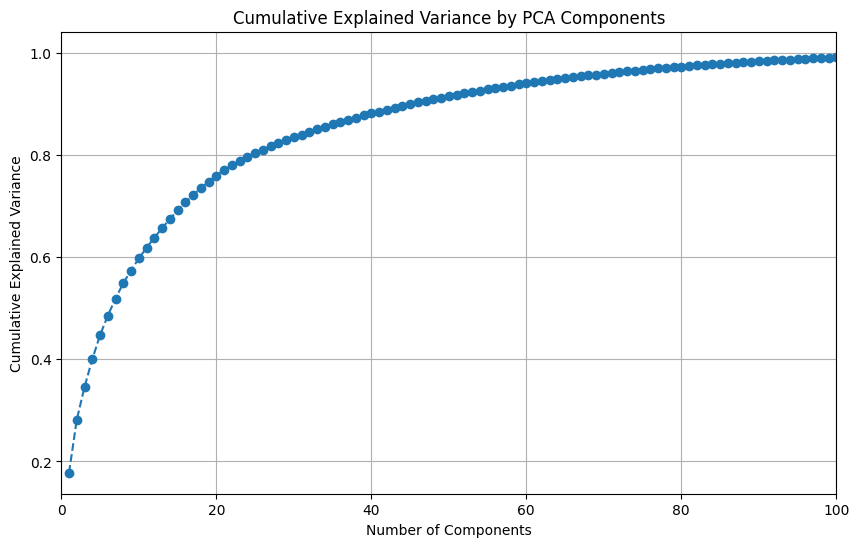

In [ ]:
pca = PCA().fit(X_train_scaled)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xlim(0,100)
plt.grid(True)
plt.show()

In [ ]:
# Apply PCA (to reduce dimensionality)
pca = PCA(n_components=35)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# You can also check the amount of variance explained by each component
total_variance_explained = sum(pca.explained_variance_ratio_)
print(f"Total Variance Explained by 35 Components: {total_variance_explained:.2f}")

Total Variance Explained by 35 Components: 0.86


# 13. Logistic regression

**Logistic Regression** is used for binary classification, where the goal is to predict one of two outcomes (e.g., "disease" or "no disease"). It estimates the probability of an event happening using a logistic function that outputs values between 0 and 1. If the probability is greater than 0.5, the model classifies the input as positive (e.g., the patient has the disease).

Logistic regression outputs the probability of having the disease. For example, if the model predicts a probability of 0.75, it classifies the patient as having the disease.

***The metrics:*** (check formula)

**Precision** tells you how many of the patients predicted to have heart disease actually have it.
**Recall** tells you how well the model identified all the patients who truly have heart disease.
**F1-Score** provides a balance between precision and recall.
**Accuracy** shows how often the model was correct overall, but it can be misleading if there is class imbalance (e.g., many more patients without heart disease than with).

In [ ]:
# Calculating optimal class weights
classes = np.arange(y_train.shape[1])
class_weights = compute_class_weight(
    'balanced',
    classes=classes,
    y=np.argmax(y_train, axis=1)
)

# Applying Logistic Regression
log_reg = LogisticRegression(class_weight=dict(enumerate(class_weights)))

# Use MultiOutputClassifier to handle multi-label classification
multi_log_reg = MultiOutputClassifier(log_reg, n_jobs=-1)

# Train the model on the training data
multi_log_reg.fit(X_train_pca, y_train)

# Make predictions on the test data
y_pred_log_reg = multi_log_reg.predict(X_test_pca)

# Evaluate the Logistic Regression model
print(classification_report(y_test, y_pred_log_reg))

# Pick out accuracy
report = classification_report(y_test, y_pred_log_reg, output_dict=True)
micro_recall = report['micro avg']['recall']
overall_accuracy = micro_recall * 100

print(f"Overall Accuracy: {overall_accuracy}")

              precision    recall  f1-score   support

           0       0.58      0.97      0.73      2119
           1       0.31      0.75      0.44       492
           2       0.12      0.06      0.08       218
           3       0.20      0.01      0.02        76
           4       0.20      0.44      0.27       684
           5       0.30      0.60      0.40       202
           6       0.33      0.17      0.23        23
           7       0.13      0.12      0.13        73
           8       0.70      0.99      0.82      5122
           9       0.27      0.85      0.41      1441

   micro avg       0.50      0.88      0.63     10450
   macro avg       0.32      0.50      0.35     10450
weighted avg       0.54      0.88      0.66     10450
 samples avg       0.61      0.92      0.68     10450

Overall Accuracy: 87.78947368421053


#Citations
Zheng, Jianwei, et al. "A large scale 12-lead electrocardiogram database for arrhythmia study" (version 1.0.0). PhysioNet (2022). RRID:SCR_007345. https://doi.org/10.13026/wgex-er52